#  Exploratory data analysis and Pre-Processing for CNN-DailyMail Data. 

Following are the high level pre-processing steps:

* **Step-1 :** Define text processing functions.
* **Step-2 :** Load data from CNN-DailyMail text files. 
 * tran.tok.txt
 * desc.tok.txt
* **Step-3 :** Experimenting with entities. 
* **Step-4 :** Data Visualizaition 
* **Step-5 :** Save dataset as CSV for use in next step (building a model) 

Output CSV Column Description:
* **summary  :** Summary provided with the article.  
* **article  :** Raw text of the article from CNN-DailyMail. 
* **data_source  :** Source of Data which is CNN-DailyMail dataset.  
* **article_pp1  :** Processed text of the article - Remove stop words, punctuations and lemmatize text. 
* **article_pp2  :** Processed text of the article - Fix duplicate punctuations and remove line breks and other items.  
* **num_words_article  :** Num of words in the article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article  :** Num of sentences in the article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_summary  :**  Num of words in the summary. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_summary  :** Num of sentences in the summary. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_article_pp1  :**  Num of words in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article_pp1  :** Num of sentences in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_article_pp2  :**  Num of words in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article_pp2  :** Num of sentences in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  

In [1]:
import re
import string
import os 
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_md
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nlp import load_dataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
nlp = en_core_web_md.load()
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

[nltk_data] Downloading package wordnet to /home/sunitc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sunitc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Step-1 : Define text processing functions.

In [2]:
####################
# Clean Text Fxnx  #
####################

# Remove invalid and foreign words. 
def remove_non_en_words(text):
    valid_words = [w for w in text.split() if w in english_vocab]
    return " ".join(valid_words)

# Remove stop words
def remove_Stopwords(text):
    stop_words = set(stopwords.words('english')) 
    words = word_tokenize( text.lower() ) 
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)
    
# Lemmatize the text
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 

# Clean text - remove special characters, extra spaces, .. 
def clean_text2(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr]) 
    return text2.lower()

# check to see if item is NAN.
def isNaN(num):
    return num != num

# Remove special characters and other items like double punctuations and carriage returns. 
def Clean_Text(out):
    if isNaN(out):
        return out
    else:
        if not out.strip().isspace():
            #out = out.replace('0', '')        
            out = out.strip()
            out = out.replace('(CNN) --', ' ')
            out = out.replace('\\x92', ' ')
            out = out.replace('\\x93', ' ')
            out = out.replace('\\x94', ' ')
            out = out.replace('\\x96', ' ')
            out = out.replace('/', ' ')
            out = out.replace('%20', ' ')
            out = out.replace('"', ' ')
            out = out.replace('\\', ' ')
            out = out.replace(';', '')
            out = out.replace('...', '.')
            out = out.replace('.,', '.')
            out = out.replace('?', '? ')
            out = out.replace('!', '! ')
            out = out.replace(',', ', ')
            out = out.replace('’', '\'')
            out = out.replace('`', '\'')
            out = out.replace('\r\n', '.')     
            out = out.replace('\n', '.') 
            out = out.replace('hey', ' ')
            out = out.replace('hi there', ' ')
            out = out.replace('.o.k.', 'ok')
            out = out.replace('o.k.', 'ok')
            out = out.replace('n''t', 'not')
            out = out.replace('hello', ' ')
            out = out.replace('°', ' degrees ')
            out = out.replace('  ', ' ')
            out = out.replace('..', '.')
            out = out.replace('..,', '.')
            out = out.replace('. ,', '.')
            out = out.replace('.,', '.')
            
        return out

    
def Get_String_Len(text):
    return len(text)

def Get_Num_Words(text):
    if type(text) == str:
        return len(text.split())
    else:
        return 0
    
def Get_Num_Sentences(text):
    if type(text) == str and '.' in text:
        return len(text.split('.'))
    else:
        return 1    

#  Step-2 : Load data from CNN-Dailymail online Dataset

In [3]:
# Load the DataSet from 
cnn_dm_dataset = load_dataset("cnn_dailymail", '3.0.0', split="train")
cnn_dm_dataset

Dataset(features: {'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}, num_rows: 287113)

In [4]:
# convert to DataFrame
cnn_dm_df = pd.DataFrame(data=cnn_dm_dataset, columns=cnn_dm_dataset.column_names)

cnn_dm_df['data_source'] = 'CNN-DailyMail'
cnn_dm_df = cnn_dm_df[['highlights','article','data_source']]
cnn_dm_df.columns = ['summary','article','data_source']


cnn_dm_df

,summary,article,data_source
0,Syrian official: Obama climbed to the top of t...,It's official: U.S. President Barack Obama wan...,CNN-DailyMail
1,Usain Bolt wins third gold of world championsh...,(CNN) -- Usain Bolt rounded off the world cham...,CNN-DailyMail
2,The employee in agency's Kansas City office is...,"Kansas City, Missouri (CNN) -- The General Ser...",CNN-DailyMail
3,NEW: A Canadian doctor says she was part of a ...,Los Angeles (CNN) -- A medical doctor in Vanco...,CNN-DailyMail
4,Another arrest made in gang rape outside Calif...,(CNN) -- Police arrested another teen Thursday...,CNN-DailyMail
...,...,...,...
287108,"Woods said: ’Guys, give me a little f***ing sp...",Tiger Woods’s frustration at the lamentable st...,CNN-DailyMail
287109,13 sailors died in 1804 after explosives ship ...,By . Mark Duell . Last updated at 4:07 PM on 2...,CNN-DailyMail
287110,Hannah Smith's father says Ask.fm's safety cha...,"Suicide: Troll victim Hannah Smith, 14, killed...",CNN-DailyMail
287111,A test version of Windows 8.1 is available to ...,By . Victoria Woollaston and Mark Prigg . PUBL...,CNN-DailyMail


In [5]:
# remove intro from article, remove stop words, lemmatize and clean text. 

cnn_dm_df['article_pp1'] = cnn_dm_df['article'].apply(clean_text2)
cnn_dm_df['article_pp1'] = cnn_dm_df['article_pp1'].apply(remove_Stopwords)
cnn_dm_df['article_pp1'] = cnn_dm_df['article_pp1'].apply(lemmatize_text)
cnn_dm_df

,summary,article,data_source,article_pp1
0,Syrian official: Obama climbed to the top of t...,It's official: U.S. President Barack Obama wan...,CNN-DailyMail,official u president barack obama want lawmake...
1,Usain Bolt wins third gold of world championsh...,(CNN) -- Usain Bolt rounded off the world cham...,CNN-DailyMail,cnn usain bolt rounded world championship sund...
2,The employee in agency's Kansas City office is...,"Kansas City, Missouri (CNN) -- The General Ser...",CNN-DailyMail,kansa city missouri cnn general service admini...
3,NEW: A Canadian doctor says she was part of a ...,Los Angeles (CNN) -- A medical doctor in Vanco...,CNN-DailyMail,los angeles cnn medical doctor vancouver briti...
4,Another arrest made in gang rape outside Calif...,(CNN) -- Police arrested another teen Thursday...,CNN-DailyMail,cnn police arrested another teen thursday sixt...
...,...,...,...,...
287108,"Woods said: ’Guys, give me a little f***ing sp...",Tiger Woods’s frustration at the lamentable st...,CNN-DailyMail,tiger wood ’ frustration lamentable state game...
287109,13 sailors died in 1804 after explosives ship ...,By . Mark Duell . Last updated at 4:07 PM on 2...,CNN-DailyMail,mark duell last updated 407 pm 23rd august 201...
287110,Hannah Smith's father says Ask.fm's safety cha...,"Suicide: Troll victim Hannah Smith, 14, killed...",CNN-DailyMail,suicide troll victim hannah smith 14 killed bu...
287111,A test version of Windows 8.1 is available to ...,By . Victoria Woollaston and Mark Prigg . PUBL...,CNN-DailyMail,victoria woollaston mark prigg published 1120 ...


In [6]:
cnn_dm_df['article_pp2'] = cnn_dm_df['article'].apply(Clean_Text)
cnn_dm_df

,summary,article,data_source,article_pp1,article_pp2
0,Syrian official: Obama climbed to the top of t...,It's official: U.S. President Barack Obama wan...,CNN-DailyMail,official u president barack obama want lawmake...,It's official: U.S. Presidenot Barack Obama wa...
1,Usain Bolt wins third gold of world championsh...,(CNN) -- Usain Bolt rounded off the world cham...,CNN-DailyMail,cnn usain bolt rounded world championship sund...,Usain Bolt rounded off the world championship...
2,The employee in agency's Kansas City office is...,"Kansas City, Missouri (CNN) -- The General Ser...",CNN-DailyMail,kansa city missouri cnn general service admini...,"Kansas City, Missouri The General Services Ad..."
3,NEW: A Canadian doctor says she was part of a ...,Los Angeles (CNN) -- A medical doctor in Vanco...,CNN-DailyMail,los angeles cnn medical doctor vancouver briti...,"Los Angeles A medical doctor in Vancouver, Br..."
4,Another arrest made in gang rape outside Calif...,(CNN) -- Police arrested another teen Thursday...,CNN-DailyMail,cnn police arrested another teen thursday sixt...,"Police arrested another teen Thursday, the si..."
...,...,...,...,...,...
287108,"Woods said: ’Guys, give me a little f***ing sp...",Tiger Woods’s frustration at the lamentable st...,CNN-DailyMail,tiger wood ’ frustration lamentable state game...,Tiger Woods's frustration at the lamenotable s...
287109,13 sailors died in 1804 after explosives ship ...,By . Mark Duell . Last updated at 4:07 PM on 2...,CNN-DailyMail,mark duell last updated 407 pm 23rd august 201...,By . Mark Duell . Last updated at 4:07 PM on 2...
287110,Hannah Smith's father says Ask.fm's safety cha...,"Suicide: Troll victim Hannah Smith, 14, killed...",CNN-DailyMail,suicide troll victim hannah smith 14 killed bu...,"Suicide: Troll victim Hannah Smith, 14, killed..."
287111,A test version of Windows 8.1 is available to ...,By . Victoria Woollaston and Mark Prigg . PUBL...,CNN-DailyMail,victoria woollaston mark prigg published 1120 ...,By . Victoria Woollaston and Mark Prigg . PUBL...


In [7]:
# remove non words. 
cnn_dm_df['article_pp3'] = cnn_dm_df['article_pp1'].apply(remove_non_en_words)
cnn_dm_df

,summary,article,data_source,article_pp1,article_pp2,article_pp3
0,Syrian official: Obama climbed to the top of t...,It's official: U.S. President Barack Obama wan...,CNN-DailyMail,official u president barack obama want lawmake...,It's official: U.S. Presidenot Barack Obama wa...,official u president want lawmaker weigh wheth...
1,Usain Bolt wins third gold of world championsh...,(CNN) -- Usain Bolt rounded off the world cham...,CNN-DailyMail,cnn usain bolt rounded world championship sund...,Usain Bolt rounded off the world championship...,bolt rounded world championship sunday third g...
2,The employee in agency's Kansas City office is...,"Kansas City, Missouri (CNN) -- The General Ser...",CNN-DailyMail,kansa city missouri cnn general service admini...,"Kansas City, Missouri The General Services Ad...",kansa city missouri general service administra...
3,NEW: A Canadian doctor says she was part of a ...,Los Angeles (CNN) -- A medical doctor in Vanco...,CNN-DailyMail,los angeles cnn medical doctor vancouver briti...,"Los Angeles A medical doctor in Vancouver, Br...",medical doctor british columbia said thursday ...
4,Another arrest made in gang rape outside Calif...,(CNN) -- Police arrested another teen Thursday...,CNN-DailyMail,cnn police arrested another teen thursday sixt...,"Police arrested another teen Thursday, the si...",police another teen thursday sixth suspect con...
...,...,...,...,...,...,...
287108,"Woods said: ’Guys, give me a little f***ing sp...",Tiger Woods’s frustration at the lamentable st...,CNN-DailyMail,tiger wood ’ frustration lamentable state game...,Tiger Woods's frustration at the lamenotable s...,tiger wood frustration lamentable state game b...
287109,13 sailors died in 1804 after explosives ship ...,By . Mark Duell . Last updated at 4:07 PM on 2...,CNN-DailyMail,mark duell last updated 407 pm 23rd august 201...,By . Mark Duell . Last updated at 4:07 PM on 2...,mark last august buried year around mile away ...
287110,Hannah Smith's father says Ask.fm's safety cha...,"Suicide: Troll victim Hannah Smith, 14, killed...",CNN-DailyMail,suicide troll victim hannah smith 14 killed bu...,"Suicide: Troll victim Hannah Smith, 14, killed...",suicide troll victim smith father teenage girl...
287111,A test version of Windows 8.1 is available to ...,By . Victoria Woollaston and Mark Prigg . PUBL...,CNN-DailyMail,victoria woollaston mark prigg published 1120 ...,By . Victoria Woollaston and Mark Prigg . PUBL...,victoria mark june june officially window upda...


In [8]:
# extract one article and one summary value from dataframe 

print("Displaying 1 Article and Summary")
article = cnn_dm_df.iloc[227]['article']
summary = cnn_dm_df.iloc[227]['summary']
print("---Summary--------------------------------------------------------------------------------------------------------")
print(summary)
print("---Article--------------------------------------------------------------------------------------------------------")
print(article)


Displaying 1 Article and Summary
---Summary--------------------------------------------------------------------------------------------------------
A trio of old friends from Baghdad have started a controversial talk show .
It's proved a hit with their predominantly male audience .
But not everyone appreciates the humor, which often involves sexual innuendo .
A religious group staged a demonstration outside the show's studio last year .
---Article--------------------------------------------------------------------------------------------------------
(CNN) -- Beset by war and sectarian violence, Iraq has not had a lot to laugh about in recent years. But a trio of old friends from Baghdad have sought to change that, by distilling the jokey banter of their late-night drinking sessions into a controversial talk show. Hosted by Yasser Sami and Walid Monam, and produced by their friend Ghazwan Al-Shawi, the show is called "Akou Fad Wahad" -- "There is this guy" -- the typical setup for one o

In [9]:
# use nlp to load article in third row of dataset. (random row)
article = cnn_dm_df.iloc[111]['article']
summary = cnn_dm_df.iloc[111]['summary']
script_article = nlp(article)
displacy.render(script_article, jupyter=True, style='ent')

In [10]:
cnn_dm_df.columns

Index(['summary', 'article', 'data_source', 'article_pp1', 'article_pp2',
       'article_pp3'],
      dtype='object')

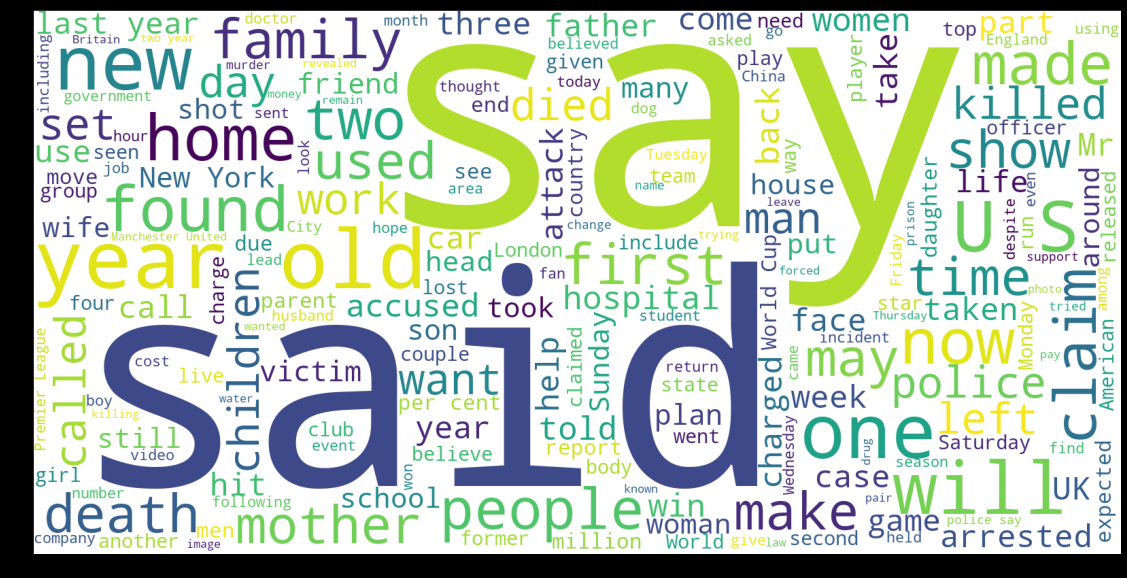

In [11]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(cnn_dm_df['summary'].tolist()))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [12]:
print("Top words in the CNN-Dailymail Articles")
print(wordcloud.words_.keys())

Top words in the CNN-Dailymail Articles
dict_keys(['say', 'said', 'year old', 'new', 'one', 'will', 'U S', 'now', 'home', 'found', 'claim', 'made', 'two', 'people', 'first', 'family', 'death', 'may', 'show', 'make', 'time', 'mother', 'used', 'police', 'set', 'killed', 'died', 'day', 'want', 'left', 'man', 'children', 'called', 'work', 'hospital', 'women', 'back', 'told', 'take', 'win', 'accused', 'car', 'Mr', 'part', 'use', 'arrested', 'face', 'charged', 'three', 'attack', 'call', 'help', 'come', 'UK', 'father', 'week', 'case', 'year', 'hit', 'taken', 'last year', 'life', 'game', 'New York', 'many', 'plan', 'friend', 'victim', 'son', 'house', 'put', 'around', 'still', 'school', 'took', 'wife', 'shot', 'head', 'Sunday', 'woman', 'per cent', 'parent', 'see', 'World Cup', 'move', 'men', 'daughter', 'country', 'expected', 'due', 'report', 'million', 'end', 'Saturday', 'group', 'team', 'former', 'second', 'couple', 'live', 'state', 'another', 'believe', 'World', 'girl', 'given', 'star', 'Lo

#  Step-5 Save dataset as CSV for use in next step (building a model) 

In [13]:
# write dataframe to file for use in next step of summarization

cnn_dm_df["num_words_article"] = cnn_dm_df['article'].apply(Get_Num_Words)
cnn_dm_df["num_sentences_article"] = cnn_dm_df['article'].apply(Get_Num_Sentences)

cnn_dm_df["num_words_summary"] = cnn_dm_df['summary'].apply(Get_Num_Words)
cnn_dm_df["num_sentences_summary"] = cnn_dm_df['summary'].apply(Get_Num_Sentences)

cnn_dm_df["num_words_article_pp1"] = cnn_dm_df['article_pp1'].apply(Get_Num_Words)
cnn_dm_df["num_sentences_article_pp1"] = cnn_dm_df['article_pp1'].apply(Get_Num_Sentences)

cnn_dm_df["num_words_article_pp2"] = cnn_dm_df['article_pp2'].apply(Get_Num_Words)
cnn_dm_df["num_sentences_article_pp2"] = cnn_dm_df['article_pp2'].apply(Get_Num_Sentences)

cnn_dm_df["num_words_article_pp3"] = cnn_dm_df['article_pp3'].apply(Get_Num_Words)
cnn_dm_df["num_sentences_article_pp3"] = cnn_dm_df['article_pp3'].apply(Get_Num_Sentences)

cnn_dm_df.to_csv(os.getcwd() + "/data/cnn_dm_df.csv")